# Static field plots

Depict urban areas as seen by the RCM

In [1]:
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
city = 'Tokyo'
ucdb_info = gpd.read_file('data/GHS_FUA_UCD/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg')
ucdb_city = ucdb_info.query(f'UC_NM_MN =="{city}"').to_crs(crs = 'EPSG:4326')
ucdb_city

,ID_HDC_G0,QA2_1V,AREA,BBX_LATMN,BBX_LONMN,BBX_LATMX,BBX_LONMX,GCPNT_LAT,GCPNT_LON,CTR_MN_NM,...,EX_SS_P00,EX_SS_P15,EX_EQ19PGA,EX_EQ19MMI,EX_EQ19_Q,EX_HW_IDX,SDG_LUE9015,SDG_A2G14,SDG_OS15MX,geometry
12963,12964.0,1.0,5318.0,35.172611,139.085831,36.187834,140.291773,35.681481,139.649416,Japan,...,1.018637e+07,1.121684e+07,0.76913,8.0,available,3.93038,0.59413,0.104006,31.08,"MULTIPOLYGON (((139.36174 36.18783, 139.41872 ..."


In [3]:
clon = ucdb_city.centroid.x.values[0]
clat = ucdb_city.centroid.y.values[0]

/tmp/ipykernel_94655/3808520748.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clon = ucdb_city.centroid.x.values[0]
/tmp/ipykernel_94655/3808520748.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clat = ucdb_city.centroid.y.values[0]


In [4]:
ords = xr.open_dataset('data/REMO/orography/orog_EAS-22_MPI-M-MPI-ESM-LR_historical_r0i0p0_GERICS-REMO2015_v1_fx_r0i0p0.nc')
lfds = xr.open_dataset('data/REMO/land-sea-mask/sftlf_EAS-22_ECMWF-ERAINT_evaluation_r0i0p0_GERICS-REMO2015_v1_fx_r0i0p0.nc')
ufds_orig = xr.open_dataset('data/REMO/urbanfraction/orig/EAS-22.nc')

Fix the raw urban fraction data

In [5]:
ufnp = ufds_orig.var493.values[0,9:-9,9:-9].copy()
ufds = lfds.assign(sftuf = (('rlat','rlon'), ufnp, dict(
  long_name = 'Urban fraction',
  standard_name = 'urban_area_fraction',
  units = '1',
  cell_measures = 'area: areacella',
  grid_mapping = 'rotated_latitude_longitude'
))).drop_vars('sftlf')
ufds.to_netcdf('sftuf_EAS-22_ECMWF-ERAINT_evaluation_r0i0p0_GERICS-REMO2015_v1_fx_r0i0p0.nc')

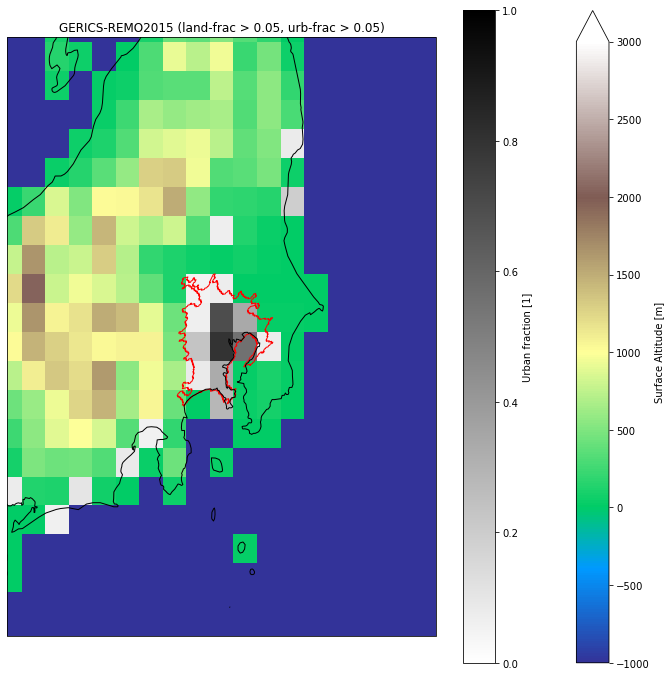

In [6]:
urban_thres = 0.05
land_thres = 0.05

projvar = ords.orog.grid_mapping
proj = ccrs.RotatedPole(
  pole_longitude=ords[projvar].grid_north_pole_longitude,
  pole_latitude=ords[projvar].grid_north_pole_latitude
)
lonlat = ccrs.PlateCarree()
size = 2. # degrees around city center
f = plt.figure(figsize=(12,12))
ax = plt.axes(projection=proj)
ords.orog.where(lfds.sftlf > land_thres*100).fillna(-1000).plot(
    ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.terrain, vmin=-1000, vmax=3000
)
ufds.sftuf.where(ufds.sftuf > urban_thres).plot(
    ax=ax, x='lon', y='lat', transform=lonlat, cmap=plt.cm.gray_r, vmin=0, vmax=1
)
ax.set_extent([clon-size, clon+size, clat-size, clat+size], crs=lonlat)
plt.title(f'{ords.model_id} (land-frac > {land_thres}, urb-frac > {urban_thres})')
ax.coastlines(resolution='10m', linewidth=1, color='k')
t = ucdb_city.plot(ax=ax, transform=lonlat, facecolor="none", edgecolor="red")